In [ ]:
import torch
from torch import nn,optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import precision_recall_fscore_support,confusion_matrix
import re
import argparse
import numpy as np

In [ ]:
def parse_file (path):
# Returns a list which containings tokenized sentences with respective POS tags for the words
# Format - [[[words of sentence i],[POS tags for the words in sentence i]],...]
    data = []
    with open (path, 'r', encoding='utf-8') as file:
        words = []
        tags = []
        for line in file:
            line = line.strip()                   # Removing the leading and trailing Blankspaces.
            if line and line[0].isdigit():
                parts = line.split("\t")
                if parts[0] == '1' and len(words) != 0:
                    sentence_data = [words, tags]
                    data.append(sentence_data)
                    words = [parts[1]]
                    tags = [parts[3]]
                else :
                    words.append(parts[1])
                    tags.append(parts[3])
    return data

In [ ]:
dev_data = parse_file("en_atis-ud-dev.conllu")
train_data = parse_file("en_atis-ud-train.conllu")
test_data = parse_file("en_atis-ud-test.conllu")

In [ ]:
# Creating a word index and tag index dictionary
def get_index_dict (data):
    k = 0
    j = 0
    vocab = {}
    tags = {}
    for sentence in data:
        for i in range (0,len(sentence[0])):
            if sentence[0][i] not in vocab:
                vocab[sentence[0][i]] = k
                k += 1
            if sentence[1][i] not in tags:
                tags[sentence[1][i]] = j
                j += 1
    vocab['<unk>'] = k
    vocab['<s>'] = k+1
    vocab['<\s>'] = k+2
    vocab['<pad>'] = k+3

    tags['START'] = j
    tags['END'] = j+1
    tags['<pad>'] = j+2

    idx_tags = {}
    for tag in tags:
        idx_tags[tags[tag]] = tag

    return vocab,tags,idx_tags

vocab,tags,idx_tags = get_index_dict(train_data)

In [ ]:
# Adding few unknow values to training data
def handling_unknowns (train):
    flag = 0
    for sent_d in train:
        if flag % 25 == 0:
            rand_int = np.random.randint(0, len(sent_d[0]))
            train[flag][0][rand_int] = 'unk'                       # 'unk' is not a part of vocab
        flag += 1

    return train

train_data = handling_unknowns(train_data)

In [ ]:
def remove_punctuation(sentence):
    punctuation_pattern = r'[^\w\s]'
    sentence_without_punctuation = re.sub(punctuation_pattern, '', sentence)
    return sentence_without_punctuation

FEED FORWARD NEURAL NETWORK

In [ ]:
# Preparing the Training Data
def preparing_data (vocab,tags,data,p,s):
    X = []
    Y = []
    start = ['<s>']*p
    end = ['<\s>']*s
    start_tags = ['START']*p
    end_tags = ['END']*s
    for sentence_data in data:
        sentence_data[0] = start + sentence_data[0] + end
        sentence_data[1] = start_tags + sentence_data[1] + end_tags

        word2idx = []
        tag2idx = []
        for i in range (0,len(sentence_data[0])):
            if sentence_data[1][i] in tags:
                tag2idx.append(tags[sentence_data[1][i]])
                if sentence_data[0][i] in vocab:
                    word2idx.append(vocab[sentence_data[0][i]])
                else :
                    word2idx.append(vocab['<unk>'])

        for i in range(0,len(word2idx)-s-p):
            word_window = word2idx[i:(p+s+1+i)]
            X.append(word_window)
            y_vect = []
            for j in range(0,p+s+1):
                y = [float(0)]*len(tags)
                y[tag2idx[i+j]] = float(1)
                y_vect.append(y)
            Y.append(y_vect)

    ipt = torch.tensor(X)
    opt = torch.tensor(Y)

    return ipt,opt

In [ ]:
def Accuracy (y_pred,y_actual,p):
    correct = 0
    for i in range (0,y_pred.size(0)):
        if torch.equal(y_pred[i][p], y_actual[i][p]):
            correct += 1

    return (correct/y_pred.size(0))

In [ ]:
def Model_Evaluate (model,ipt,opt,p):
    model.eval()
    with torch.inference_mode():
        pred_opt = torch.round(torch.sigmoid(model(ipt).squeeze()))
    accuracy = Accuracy(pred_opt,opt,p)
    print(f"Accuracy : {accuracy}")

    pred_opt_np = pred_opt[:,p,:].detach().numpy()
    opt_np = opt[:,p,:].detach().numpy()

    _, recall_micro, f1_score_micro, _ = precision_recall_fscore_support(opt_np, pred_opt_np, average='micro',zero_division=1)
    _, recall_macro, f1_score_macro, _ = precision_recall_fscore_support(opt_np, pred_opt_np, average='macro',zero_division=1)

    print("Micro-average Recall:", recall_micro)
    print("Micro-average F1-score:", f1_score_micro)
    print("Macro-average Recall:", recall_macro)
    print("Macro-average F1-score:", f1_score_macro)

    return accuracy,recall_micro,recall_macro,f1_score_micro,f1_score_macro


In [ ]:
class FFNN_POS_Tagger (nn.Module):
    def __init__ (self,vocab_size,tagset_size,embd_dim,hd_dim):
        super().__init__()
        self.input_dim = vocab_size
        self.output_dim = tagset_size
        self.hidden = hd_dim
        self.embd = embd_dim
        # Creating an Embedding Layer
        self.embd_layer = nn.Embedding(self.input_dim,self.embd)
        # From Embedding Layer to Final Output Layer
        self.opt_predictor = nn.Sequential (nn.Linear(self.embd,self.hidden),                    # Embedding Layer to Hidden Layer
                                            nn.ReLU(),                                           # Activation Function
                                            nn.Linear(self.hidden,self.output_dim))              # Hidden Layer to Final Output
    def forward(self,idx):
        return self.opt_predictor(self.embd_layer(idx.to(torch.long)))

def ffnn_tagger(EMBD_DIM,HIDDEN_DIM,LR,X_train,Y_train):
    BATCH_SIZE = 120
    NUM_EPOCHS = 80
    ffnn_model = FFNN_POS_Tagger(len(vocab),len(tags),EMBD_DIM,HIDDEN_DIM)

    ds = TensorDataset(X_train,Y_train)
    data = DataLoader(ds,batch_size=BATCH_SIZE,shuffle=True)

    Loss = nn.BCEWithLogitsLoss()
    Optimizer = optim.SGD(params=ffnn_model.parameters(),lr = LR)

    for i in range(0,NUM_EPOCHS):
        ffnn_model.train()
        for ipt_batch, opt_batch in data:
            opt_pred = ffnn_model(ipt_batch).squeeze()
            loss = Loss(opt_pred,opt_batch)
            Optimizer.zero_grad()
            loss.backward()
            Optimizer.step()

    return ffnn_model

In [ ]:
acc = []
r_micro = []
r_macro = []
f1_micro = []
f1_macro = []
embedding_dim = []
hidden_dim = []
learning_rate = []

embd_dim = [256,128,64]
hd_dim = [256,128,64]
learn = [0.2,0.1,0.01]

x_train,y_train = preparing_data(vocab,tags,train_data,3,2)
x_test, y_test = preparing_data(vocab,tags,dev_data,3,2)

for emb in embd_dim:
  for hd in hd_dim:
    for lr in learn:
        ff_model = ffnn_tagger(emb,hd,lr,x_train,y_train)
        accuracy,recall_micro,recall_macro,f1_score_micro,f1_score_macro = Model_Evaluate(ff_model,x_test,y_test,3)
        acc.append(accuracy)
        r_micro.append(recall_micro)
        r_macro.append(recall_macro)
        f1_micro.append(f1_score_micro)
        f1_macro.append(f1_score_macro)
        embedding_dim.append(emb)
        hidden_dim.append(hd)
        learning_rate.append(lr)

Accuracy : 0.956718443673654
Micro-average Recall: 0.956718443673654
Micro-average F1-score: 0.9603390856796852
Macro-average Recall: 0.8936863848480462
Macro-average F1-score: 0.9026473175903096
Accuracy : 0.9527974664454834
Micro-average Recall: 0.9530990800784196
Micro-average F1-score: 0.9580112172199485
Macro-average Recall: 0.8828696175619384
Macro-average F1-score: 0.8951487652997727
Accuracy : 0.8609561152164078
Micro-average Recall: 0.8609561152164078
Micro-average F1-score: 0.9084254912880897
Macro-average Recall: 0.7207200865118448
Macro-average F1-score: 0.7571311576650844
Accuracy : 0.9565676368571859
Micro-average Recall: 0.9565676368571859
Micro-average F1-score: 0.9601150382199348
Macro-average Recall: 0.8936551093425602
Macro-average F1-score: 0.902363350410734
Accuracy : 0.952345045996079
Micro-average Recall: 0.952345045996079
Micro-average F1-score: 0.9580520367139498
Macro-average Recall: 0.8832420676753736
Macro-average F1-score: 0.8963720887368686
Accuracy : 0.86

In [ ]:
from tabulate import tabulate

table_data = list(zip(embedding_dim, hidden_dim, learning_rate,acc,r_micro,r_macro,f1_micro,f1_macro))

print(tabulate(table_data, headers=['Embedding Dimension', 'Hidden Dimension', 'Learning Rate', 'Accuracy', 'Recall Micro', 'Recall Macro', 'F1 Score Micro', 'F1 Score Macro']))


  Embedding Dimension    Hidden Dimension    Learning Rate    Accuracy    Recall Micro    Recall Macro    F1 Score Micro    F1 Score Macro
---------------------  ------------------  ---------------  ----------  --------------  --------------  ----------------  ----------------
                  256                 256             0.2     0.956718        0.956718        0.893686          0.960339          0.902647
                  256                 256             0.1     0.952797        0.953099        0.88287           0.958011          0.895149
                  256                 256             0.01    0.860956        0.860956        0.72072           0.908425          0.757131
                  256                 128             0.2     0.956568        0.956568        0.893655          0.960115          0.902363
                  256                 128             0.1     0.952345        0.952345        0.883242          0.958052          0.896372
                  256      

In [ ]:
acc = []
r_micro = []
r_macro = []
f1_micro = []
f1_macro = []

for i in range (1,5):
  X_train,Y_train = preparing_data(vocab,tags,train_data,i,i)
  X_test, Y_test = preparing_data(vocab,tags,dev_data,i,i)
  ff_model = ffnn_tagger(256,256,0.2,X_train,Y_train)
  accuracy,recall_micro,recall_macro,f1_score_micro,f1_score_macro = Model_Evaluate(ff_model,X_test,Y_test,i)
  acc.append(accuracy)
  r_micro.append(recall_micro)
  r_macro.append(recall_macro)
  f1_micro.append(f1_score_micro)
  f1_macro.append(f1_score_macro)


Accuracy : 0.969955724225174
Micro-average Recall: 0.969955724225174
Micro-average F1-score: 0.9724159797083068
Macro-average Recall: 0.8946139548686415
Macro-average F1-score: 0.9030556889999946
Accuracy : 0.973184042152804
Micro-average Recall: 0.973184042152804
Micro-average F1-score: 0.9753866465484723
Macro-average Recall: 0.8932349366711123
Macro-average F1-score: 0.9021924500207024
Accuracy : 0.9780824039653035
Micro-average Recall: 0.9780824039653035
Micro-average F1-score: 0.9798277601055163
Macro-average Recall: 0.8945495857809174
Macro-average F1-score: 0.9031257659446503
Accuracy : 0.9828008324152283
Micro-average Recall: 0.9828008324152283
Micro-average F1-score: 0.9840958538902338
Macro-average Recall: 0.89609277471693
Macro-average F1-score: 0.9038096809042938


In [ ]:
from tabulate import tabulate
context_window_sizes = [1, 2, 3, 4]

table_data = list(zip(context_window_sizes ,acc,r_micro,r_macro,f1_micro,f1_macro))

print(tabulate(table_data, headers=['Context Window','Accuracy', 'Recall Micro', 'Recall Macro', 'F1 Score Micro', 'F1 Score Macro']))

  Context Window    Accuracy    Recall Micro    Recall Macro    F1 Score Micro    F1 Score Macro
----------------  ----------  --------------  --------------  ----------------  ----------------
               1    0.969956        0.969956        0.894614          0.972416          0.903056
               2    0.973184        0.973184        0.893235          0.975387          0.902192
               3    0.978082        0.978082        0.89455           0.979828          0.903126
               4    0.982801        0.982801        0.896093          0.984096          0.90381


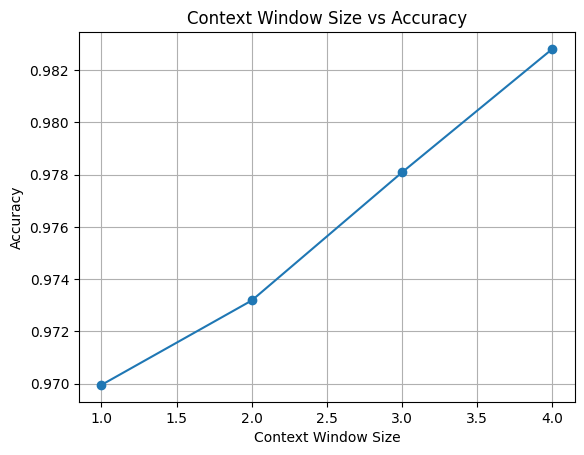

In [26]:
import matplotlib.pyplot as plt

# Example data: context window sizes and corresponding accuracies
context_window_sizes = [1, 2, 3, 4]

# Plot the graph
plt.plot(context_window_sizes, acc, marker='o')
# Add labels and title
plt.xlabel('Context Window Size')
plt.ylabel('Accuracy')
plt.title('Context Window Size vs Accuracy')

# Show grid
plt.grid(True)

# Show plot
plt.show()

RECURRENT NEURAL NETWORK

In [ ]:
def data2idx (data):
    X = []
    Y = []
    for sentence_data in data:
        word2idx = []
        tag2idx = []
        for i in range (0,len(sentence_data[0])):
            if sentence_data[1][i] in tags:
                tag2idx.append(tags[sentence_data[1][i]])
                if sentence_data[0][i] in vocab:
                    word2idx.append(vocab[sentence_data[0][i]])
                else :
                    word2idx.append(vocab['<unk>'])

        X.append(word2idx)
        y_vect = []
        for i in range (0,len(tag2idx)):
            y = [float(0)]*len(tags)
            y[tag2idx[i]] = float(1)
            y_vect.append(y)
        Y.append(y_vect)

    return X,Y

In [ ]:
def padding (X,Y):
    # Maximum Sentence Size = 60
    sentence_size = 60
    y = [float(0)]*len(tags)
    y[tags['<pad>']] = float(1)
    for i in range (0,len(X)):
        sz = sentence_size - len(X[i])
        X[i] = X[i] + sz*[vocab['<pad>']]
        for j in range (0,sz):
            Y[i].append(y)
            j += 1

    ipt = torch.tensor(X)
    opt = torch.tensor(Y)

    return ipt,opt

In [ ]:
def Evaluate_LSTM (lstm_model,BATCH_SIZE):
    # Loading the Test Data
    test_x,test_y = data2idx(dev_data)
    test_ipt,test_opt = padding(test_x,test_y)
    ds_test = TensorDataset(test_ipt,test_opt)
    test_loader = DataLoader(ds_test,batch_size=120,shuffle=True)

    pad = [float(0)]*len(tags)
    pad[tags['<pad>']] = float(1)
    pad_tensor = torch.tensor(pad)
    model_predictions = []
    actual_values = []
    correct = 0
    total = 0
    for ipt_test, opt_test in test_loader:
        lstm_model.initial_hd = (torch.zeros(1,min(BATCH_SIZE,len(ipt_test)),lstm_model.hidden),torch.zeros(1,min(BATCH_SIZE,len(ipt_test)),lstm_model.hidden))

        lstm_model.eval()
        with torch.inference_mode():
            pred_opt = torch.round(torch.sigmoid(lstm_model(ipt_test).squeeze()))

        for val in range (0,len(pred_opt)):
            for k in range (0,len(pred_opt[val])):
                if not torch.equal(opt_test[val][k],pad_tensor):
                    if torch.equal(opt_test[val][k],pred_opt[val][k]):
                        correct += 1
                        total += 1
                    else :
                        total += 1
                else:
                    model_predictions.append(pred_opt[val][:k].detach().numpy())
                    actual_values.append(opt_test[val][:k].detach().numpy())
                    break


    model_predictions = np.concatenate(model_predictions)
    actual_values = np.concatenate(actual_values)

    accuracy = correct/total
    _, recall_micro, f1_score_micro, _ = precision_recall_fscore_support(model_predictions, actual_values, average='micro',zero_division=1)
    _, recall_macro, f1_score_macro, _ = precision_recall_fscore_support(model_predictions, actual_values, average='macro',zero_division=1)

    print(f"Accuracy : {accuracy}")
    print("Micro-average Recall:", recall_micro)
    print("Micro-average F1-score:", f1_score_micro)
    print("Macro-average Recall:", recall_macro)
    print("Macro-average F1-score:", f1_score_macro)

    return accuracy,recall_micro,recall_macro,f1_score_micro,f1_score_macro


In [ ]:
class LSTM_POS_Tagger (nn.Module):
    def __init__ (self,vocab_size,tagset_size,embd_dim,hd_dim,batch_size):
        super().__init__()
        self.input_dim = vocab_size
        self.output_dim = tagset_size
        self.hidden = hd_dim
        self.embd = embd_dim
        self.batch_size = batch_size
        # Creating an Embedding Layer
        self.embd_layer = nn.Embedding(self.input_dim,self.embd)
        # From Embedding Layer to Final Output Layer
        self.lstm_layer = nn.LSTM(self.embd,self.hidden,batch_first=True)
        self.hidden_layer = nn.Linear(self.hidden,self.output_dim)

        # dimensions (no. of lstm layer, batch size 1 (processing one sentence at a time), hidden_layer dimensions)
        # initializing the hidden layer to zero for first iteration
        self.initial_hd = (torch.zeros(1,self.batch_size,self.hidden),torch.zeros(1,self.batch_size,self.hidden))

    def forward(self,batch):
        embd_layer = self.embd_layer(batch)
        lstm_layer, self.initial_hiddenlayer = self.lstm_layer(embd_layer,self.initial_hd)
        tag_layer = self.hidden_layer(lstm_layer)

        return tag_layer

def lstm_tagger(EMBD_DIM,HIDDEN_DIM,LR):
    BATCH_SIZE = 120
    NUM_EPOCHS = 30

    X,Y = data2idx(train_data)
    ipt,opt = padding(X,Y)

    lstm_model = LSTM_POS_Tagger(len(vocab),len(tags),EMBD_DIM,HIDDEN_DIM,BATCH_SIZE)

    ds = TensorDataset(ipt,opt)
    data = DataLoader(ds,batch_size=BATCH_SIZE,shuffle=True)

    Loss = nn.BCEWithLogitsLoss()
    Optimizer = optim.Adam(params=lstm_model.parameters(),lr = LR)

    for i in range(0,NUM_EPOCHS):
        for ipt_batch, opt_batch in data:

            lstm_model.initial_hd = (torch.zeros(1,min(BATCH_SIZE,len(ipt_batch)),lstm_model.hidden),torch.zeros(1,min(BATCH_SIZE,len(ipt_batch)),lstm_model.hidden))
            pred_tags = lstm_model(ipt_batch)
            loss = Loss(pred_tags,opt_batch)
            Optimizer.zero_grad()
            loss.backward()
            Optimizer.step()

    return lstm_model


In [ ]:
acc = []
r_micro = []
r_macro = []
f1_micro = []
f1_macro = []
embedding_dim = []
hidden_dim = []
learning_rate = []

lstm_model = lstm_tagger(256,256,0.2)
accuracy,recall_micro,recall_macro,f1_score_micro,f1_score_macro = Evaluate_LSTM(lstm_model,120)
acc.append(accuracy)
r_micro.append(recall_micro)
r_macro.append(recall_macro)
f1_micro.append(f1_score_micro)
f1_macro.append(f1_score_macro)
embedding_dim.append(256)
hidden_dim.append(256)
learning_rate.append(0.2)

Accuracy : 0.9463127733373549
Micro-average Recall: 0.9607425441265977
Micro-average F1-score: 0.9564492918276148
Macro-average Recall: 0.9046420562317218
Macro-average F1-score: 0.8802316074031236


In [ ]:
from tabulate import tabulate

table_data = list(zip(embedding_dim, hidden_dim, learning_rate,acc,r_micro,r_macro,f1_micro,f1_macro))

print(tabulate(table_data, headers=['Embedding Dimension', 'Hidden Dimension', 'Learning Rate', 'Accuracy', 'Recall Micro', 'Recall Macro', 'F1 Score Micro', 'F1 Score Macro']))

  Embedding Dimension    Hidden Dimension    Learning Rate    Accuracy    Recall Micro    Recall Macro    F1 Score Micro    F1 Score Macro
---------------------  ------------------  ---------------  ----------  --------------  --------------  ----------------  ----------------
                  256                 256              0.2    0.946313        0.960743        0.904642          0.956449          0.880232


In [ ]:
lstm_model = lstm_tagger(256,128,0.2)
accuracy,recall_micro,recall_macro,f1_score_micro,f1_score_macro = Evaluate_LSTM(lstm_model,120)
acc.append(accuracy)
r_micro.append(recall_micro)
r_macro.append(recall_macro)
f1_micro.append(f1_score_micro)
f1_macro.append(f1_score_macro)
embedding_dim.append(256)
hidden_dim.append(128)
learning_rate.append(0.2)

Accuracy : 0.9426934097421203
Micro-average Recall: 0.963969465648855
Micro-average F1-score: 0.9580456718003186
Macro-average Recall: 0.9585267170736467
Macro-average F1-score: 0.9356461641491347


In [ ]:
from tabulate import tabulate

table_data = list(zip(embedding_dim, hidden_dim, learning_rate,acc,r_micro,r_macro,f1_micro,f1_macro))

print(tabulate(table_data, headers=['Embedding Dimension', 'Hidden Dimension', 'Learning Rate', 'Accuracy', 'Recall Micro', 'Recall Macro', 'F1 Score Micro', 'F1 Score Macro']))

  Embedding Dimension    Hidden Dimension    Learning Rate    Accuracy    Recall Micro    Recall Macro    F1 Score Micro    F1 Score Macro
---------------------  ------------------  ---------------  ----------  --------------  --------------  ----------------  ----------------
                  256                 256              0.2    0.946313        0.960743        0.904642          0.956449          0.880232
                  256                 128              0.2    0.942693        0.963969        0.958527          0.958046          0.935646


In [ ]:
lstm_model = lstm_tagger(128,64,0.2)
accuracy,recall_micro,recall_macro,f1_score_micro,f1_score_macro = Evaluate_LSTM(lstm_model,120)
acc.append(accuracy)
r_micro.append(recall_micro)
r_macro.append(recall_macro)
f1_micro.append(f1_score_micro)
f1_macro.append(f1_score_macro)
embedding_dim.append(128)
hidden_dim.append(64)
learning_rate.append(0.2)

Accuracy : 0.9250490122153522
Micro-average Recall: 0.9653457653457653
Micro-average F1-score: 0.9508648400428592
Macro-average Recall: 0.9569210223964875
Macro-average F1-score: 0.9228023969106867


In [ ]:
from tabulate import tabulate

table_data = list(zip(embedding_dim, hidden_dim, learning_rate,acc,r_micro,r_macro,f1_micro,f1_macro))

print(tabulate(table_data, headers=['Embedding Dimension', 'Hidden Dimension', 'Learning Rate', 'Accuracy', 'Recall Micro', 'Recall Macro', 'F1 Score Micro', 'F1 Score Macro']))

  Embedding Dimension    Hidden Dimension    Learning Rate    Accuracy    Recall Micro    Recall Macro    F1 Score Micro    F1 Score Macro
---------------------  ------------------  ---------------  ----------  --------------  --------------  ----------------  ----------------
                  256                 256              0.2    0.946313        0.960743        0.904642          0.956449          0.880232
                  256                 128              0.2    0.942693        0.963969        0.958527          0.958046          0.935646
                  128                  64              0.2    0.925049        0.965346        0.956921          0.950865          0.922802


In [ ]:
lstm_model = lstm_tagger(128,64,0.1)
accuracy,recall_micro,recall_macro,f1_score_micro,f1_score_macro = Evaluate_LSTM(lstm_model,120)
acc.append(accuracy)
r_micro.append(recall_micro)
r_macro.append(recall_macro)
f1_micro.append(f1_score_micro)
f1_macro.append(f1_score_macro)
embedding_dim.append(128)
hidden_dim.append(64)
learning_rate.append(0.1)

Accuracy : 0.9565676368571859
Micro-average Recall: 0.9726132190942472
Micro-average F1-score: 0.9655958077010709
Macro-average Recall: 0.9673178349080863
Macro-average F1-score: 0.9532705660890689


In [ ]:
from tabulate import tabulate

table_data = list(zip(embedding_dim, hidden_dim, learning_rate,acc,r_micro,r_macro,f1_micro,f1_macro))

print(tabulate(table_data, headers=['Embedding Dimension', 'Hidden Dimension', 'Learning Rate', 'Accuracy', 'Recall Micro', 'Recall Macro', 'F1 Score Micro', 'F1 Score Macro']))

  Embedding Dimension    Hidden Dimension    Learning Rate    Accuracy    Recall Micro    Recall Macro    F1 Score Micro    F1 Score Macro
---------------------  ------------------  ---------------  ----------  --------------  --------------  ----------------  ----------------
                  256                 256              0.2    0.946313        0.960743        0.904642          0.956449          0.880232
                  256                 128              0.2    0.942693        0.963969        0.958527          0.958046          0.935646
                  128                  64              0.2    0.925049        0.965346        0.956921          0.950865          0.922802
                  128                  64              0.1    0.956568        0.972613        0.967318          0.965596          0.953271


In [ ]:
lstm_model = lstm_tagger(128,128,0.1)
accuracy,recall_micro,recall_macro,f1_score_micro,f1_score_macro = Evaluate_LSTM(lstm_model,120)
acc.append(accuracy)
r_micro.append(recall_micro)
r_macro.append(recall_macro)
f1_micro.append(f1_score_micro)
f1_macro.append(f1_score_macro)
embedding_dim.append(128)
hidden_dim.append(128)
learning_rate.append(0.1)

Accuracy : 0.9627507163323782
Micro-average Recall: 0.9738482590846891
Micro-average F1-score: 0.9698667474258026
Macro-average Recall: 0.971158764683915
Macro-average F1-score: 0.9581757052128985


In [ ]:
from tabulate import tabulate

table_data = list(zip(embedding_dim, hidden_dim, learning_rate,acc,r_micro,r_macro,f1_micro,f1_macro))

print(tabulate(table_data, headers=['Embedding Dimension', 'Hidden Dimension', 'Learning Rate', 'Accuracy', 'Recall Micro', 'Recall Macro', 'F1 Score Micro', 'F1 Score Macro']))

  Embedding Dimension    Hidden Dimension    Learning Rate    Accuracy    Recall Micro    Recall Macro    F1 Score Micro    F1 Score Macro
---------------------  ------------------  ---------------  ----------  --------------  --------------  ----------------  ----------------
                  256                 256              0.2    0.946313        0.960743        0.904642          0.956449          0.880232
                  256                 128              0.2    0.942693        0.963969        0.958527          0.958046          0.935646
                  128                  64              0.2    0.925049        0.965346        0.956921          0.950865          0.922802
                  128                  64              0.1    0.956568        0.972613        0.967318          0.965596          0.953271
                  128                 128              0.1    0.962751        0.973848        0.971159          0.969867          0.958176


In [ ]:
class LSTM_POS_Tagger (nn.Module):
    def __init__ (self,vocab_size,tagset_size,embd_dim,hd_dim,batch_size):
        super().__init__()
        self.input_dim = vocab_size
        self.output_dim = tagset_size
        self.hidden = hd_dim
        self.embd = embd_dim
        self.batch_size = batch_size
        # Creating an Embedding Layer
        self.embd_layer = nn.Embedding(self.input_dim,self.embd)
        # From Embedding Layer to Final Output Layer
        self.lstm_layer = nn.LSTM(self.embd,self.hidden,batch_first=True)
        self.hidden_layer = nn.Linear(self.hidden,self.output_dim)

        # dimensions (no. of lstm layer, batch size 1 (processing one sentence at a time), hidden_layer dimensions)
        # initializing the hidden layer to zero for first iteration
        self.initial_hd = (torch.zeros(1,self.batch_size,self.hidden),torch.zeros(1,self.batch_size,self.hidden))

    def forward(self,batch):
        embd_layer = self.embd_layer(batch)
        lstm_layer, self.initial_hiddenlayer = self.lstm_layer(embd_layer,self.initial_hd)
        tag_layer = self.hidden_layer(lstm_layer)

        return tag_layer

def lstm_tagger(EMBD_DIM,HIDDEN_DIM,LR):
    BATCH_SIZE = 120
    NUM_EPOCHS = 30
    ACCURACY = []
    EPOCH = []

    X,Y = data2idx(train_data)
    ipt,opt = padding(X,Y)

    lstm_model = LSTM_POS_Tagger(len(vocab),len(tags),EMBD_DIM,HIDDEN_DIM,BATCH_SIZE)

    ds = TensorDataset(ipt,opt)
    data = DataLoader(ds,batch_size=BATCH_SIZE,shuffle=True)

    Loss = nn.BCEWithLogitsLoss()
    Optimizer = optim.Adam(params=lstm_model.parameters(),lr = LR)

    for i in range(0,NUM_EPOCHS):
        for ipt_batch, opt_batch in data:

            lstm_model.initial_hd = (torch.zeros(1,min(BATCH_SIZE,len(ipt_batch)),lstm_model.hidden),torch.zeros(1,min(BATCH_SIZE,len(ipt_batch)),lstm_model.hidden))
            pred_tags = lstm_model(ipt_batch)
            loss = Loss(pred_tags,opt_batch)
            Optimizer.zero_grad()
            loss.backward()
            Optimizer.step()

        accuracy,recall_micro,recall_macro,f1_score_micro,f1_score_macro = Evaluate_LSTM(lstm_model,120)
        ACCURACY.append(accuracy)
        EPOCH.append(i)

    return lstm_model,ACCURACY,EPOCH

In [ ]:
lstm_model,ACCURACY,EPOCH = lstm_tagger(128,64,0.1)

Accuracy : 0.5668828231036043
Micro-average Recall: 0.9031358885017422
Micro-average F1-score: 0.7110460863204097
Macro-average Recall: 0.6514007736509961
Macro-average F1-score: 0.44598518117714636
Accuracy : 0.8405971949932137
Micro-average Recall: 0.9545377149667972
Micro-average F1-score: 0.8966730646193218
Macro-average Recall: 0.8719056332892963
Macro-average F1-score: 0.7290993738488588
Accuracy : 0.9312320916905444
Micro-average Recall: 0.9693030540328896
Micro-average F1-score: 0.9509834050399508
Macro-average Recall: 0.9495195165435084
Macro-average F1-score: 0.8996098135252321
Accuracy : 0.9473684210526315
Micro-average Recall: 0.9722136461870948
Micro-average F1-score: 0.9608665802120679
Macro-average Recall: 0.9583350485487304
Macro-average F1-score: 0.9252863364690058
Accuracy : 0.9482732619514402
Micro-average Recall: 0.9750658200402664
Micro-average F1-score: 0.9621026894865525
Macro-average Recall: 0.9704853542865411
Macro-average F1-score: 0.8847034224425774
Accuracy 

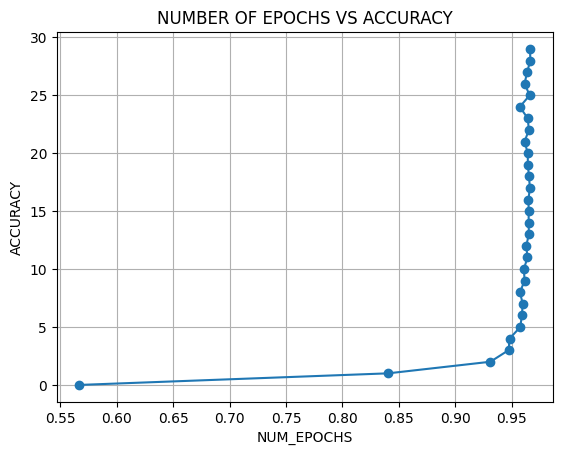

In [ ]:
import matplotlib.pyplot as plt
plt.plot(ACCURACY, EPOCH, marker='o')

# Add labels and title
plt.xlabel('NUM_EPOCHS')
plt.ylabel('ACCURACY')
plt.title('NUMBER OF EPOCHS VS ACCURACY')

# Show grid
plt.grid(True)

# Show plot
plt.show()